# Visualize L1 and L2 regularization

In [504]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from mpl_toolkits.mplot3d import Axes3D # required even though not ref'd!
import matplotlib as mpl

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

## L2

In [505]:
def plot_reg(penalty:('l1','l2')='l2',lmbda:float=1.0,show_reg=True,xrange=None,yrange=None,fill=True):
    def loss(x,y,b):
        losses = []
        for b_ in b:
            losses.append( np.sum((y - (0 + b_*x))**2) )
        return np.array(losses)
    
    mse_color = '#225ea8'
    reg_color = '#fdae61'
    sum_color = '#41b6c4'
    fig, ax = plt.subplots(1,1)
    
    # get x,y as line with slope beta = 2 + noise
    x = np.linspace(0,5,6)
    x = (x - np.mean(x)) / np.std(x)  # normalize x
    y = 2 * x# + np.random.uniform(0,1,size=len(x))
    
#     lm = LinearRegression()
#     lm.fit(x.reshape(-1,1),y)
#     print(f"Slope of data is {lm.coef_[0]}")
    
    b1 = np.linspace(0,4,1000)    
    mse = (b1-2)**2
#     mse = loss(x,y,b=b1)
    if penalty=='l1':
        reg = lmbda * np.abs(b1)
    else:
        reg = lmbda * b1**2

    if yrange is None:
        yrange = (0, max(mse))

#     print(lmbda)
#     print("b1 cross", mse / lmbda, "len mse", len(mse))
#     print("b1 cross", mse)
#     print("b1 cross no lmbda", b1[np.argmin(mse)])
    
    min_mse = np.min(mse)
    min_mse_x = 2#b1[np.argmin(mse)]
    min_loss = np.min(mse+reg)
    min_loss_x = b1[np.argmin(mse+reg)]
#     print(np.where(np.abs(mse-reg)<.01), b1[np.where(np.abs(mse-reg)<.01)])
#    print(np.where(mse==reg))#, b1[np.argmin(mse-reg)])
    ax.plot(b1, mse, lw=.75, label="$\Sigma(y-\\hat{y})^2$", c=mse_color)
    if show_reg:
        reg_label = "$\\lambda |\\beta_1|$" if penalty=='l1' else "$\\lambda \\beta_1^2$"
        ax.plot(b1, reg, lw=.3, label=reg_label, c=reg_color)
        ax.plot(b1, mse + reg, '--', lw=1, label="$(y-\\hat{y})^2$ + "+reg_label, c=sum_color)
        ax.annotate("Min mse+reg",(min_loss_x,min_loss),xytext=(min_loss_x,min_loss*1.2),
                    arrowprops=dict(arrowstyle="->"), horizontalalignment='right')
        # vertible bar
        ax.plot([min_loss_x,min_loss_x], [0,yrange[1]],lw=.5,c='grey')
        if fill:
            ax.fill_between(b1, reg, 0, color=reg_color, alpha=.15)
        delta_x = min_loss_x-min_mse_x
        delta_midpoint_x = (min_mse_x+min_loss_x)/2
        ax.text(delta_midpoint_x,yrange[1]-yrange[1]*.1,f"$\\lambda={lmbda:.2f}$ ({penalty.upper()})",
               horizontalalignment='center')
        ax.text(delta_midpoint_x,yrange[1]-yrange[1]*.15,f"$\\Delta_{{\\beta}}$={delta_x:.1f}",
               horizontalalignment='center')
#         ax.text(2,15,f"shifts min loss",
#                horizontalalignment='center')
        if not np.isclose(min_loss_x,min_mse_x):
            ax.arrow(min_mse_x, yrange[1]-yrange[1]*.03, (min_loss_x-min_mse_x), 0, lw=.5, 
                    head_length=0.05,
                    head_width=0.2,
                    length_includes_head=True)
    # verticle bar
    ax.plot([min_mse_x,min_mse_x], [0,yrange[1]],lw=.5,c='grey')
    ax.annotate("Min mse",(2,0),xytext=(2.2,2),arrowprops=dict(arrowstyle="->"))
    ax.set_xlabel("$\\beta_1$")
    ax.set_ylabel("Loss")
    if xrange is not None:
        ax.set_xlim(*xrange)
    ax.set_ylim(*yrange)
    ax.legend(loc='upper right')

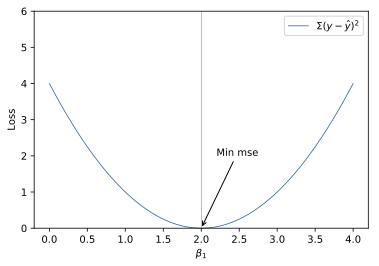

In [506]:
plot_reg('l2',show_reg=False, yrange=(0,6))

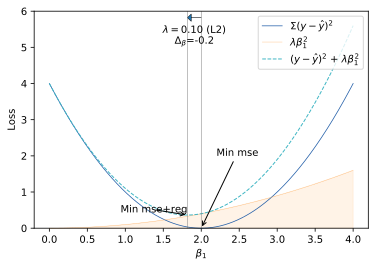

In [507]:
plot_reg('l2',lmbda=.1,yrange=(0,6))

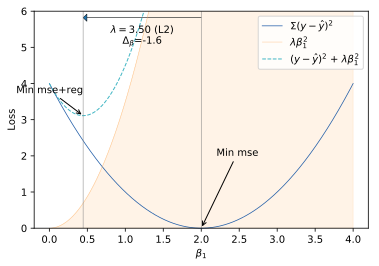

In [508]:
plot_reg('l2',lmbda=3.5, yrange=(0,6))

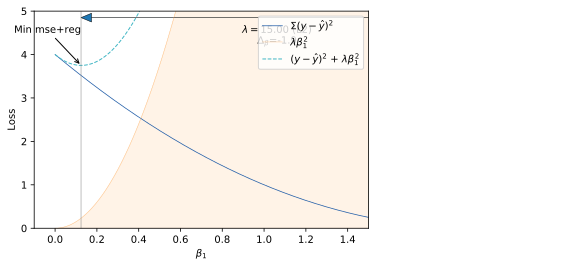

In [509]:
plot_reg('l2',lmbda=15, xrange=(-.1,1.5), yrange=(0,5)) # zoom in

## L1

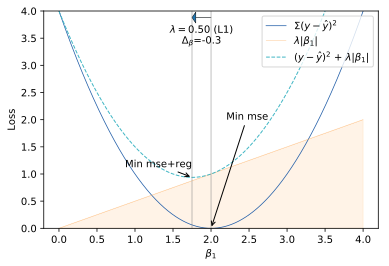

In [510]:
plot_reg('l1',lmbda=.5)

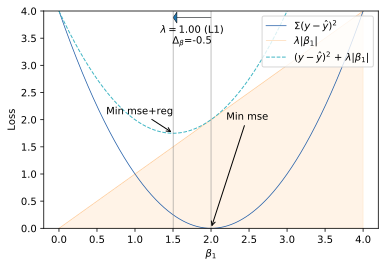

In [511]:
plot_reg('l1',lmbda=1)

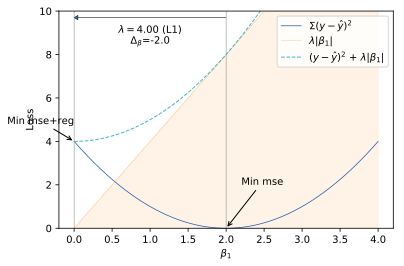

In [512]:
plot_reg('l1',lmbda=4, yrange=(0,10))

## Animate

In [513]:
import glob
import os
from PIL import Image as PIL_Image

def animate(penalty, lrange, step, yrange, dpi=100, duration=80):
    plt.close()
    for f in glob.glob(f'/tmp/{penalty}-frame-*.png'):
        os.remove(f)

    for lmbda in np.arange(*lrange,step):
        plot_reg(penalty,lmbda=lmbda,fill=False,yrange=yrange)
#         print(f"/tmp/{penalty}-frame-{lmbda:06.3f}.png")
        plt.savefig(f"/tmp/{penalty}-frame-{lmbda:06.3f}.png", bbox_inches=0, pad_inches=0, dpi=dpi)
        plt.close()

    images = [PIL_Image.open(image) for image in sorted(glob.glob(f'/tmp/{penalty}-frame-*.png'))]
    images += reversed(images)
    images[0].save(f'/tmp/{penalty}-animation.gif',
                   save_all=True,
                   append_images=images[1:],
                   duration=duration,
                   loop=0)

In [514]:
animate('l1',lrange=(0.0,5), step=.2, yrange=(0,6))

In [515]:
animate('l2',lrange=(0.0,11), step=.3, yrange=(0,6), duration=100)

## Contour plots

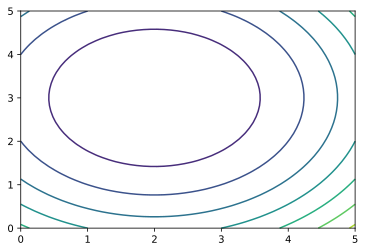

In [516]:
x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 40)

X, Y = np.meshgrid(x, y)

def f(X,Y,c1=2,c2=3): return (X-c1)**2 + (Y-c2)**2
Z = f(X, Y)

plt.contour(X, Y, Z)

In [517]:
def loss(B,X,y):
    "Line coefficients: B = [y-intercept, slope]"
    return np.mean((y - np.dot(X,np.array(B)))**2)
def get_surface(X, y, loss, b1_range, b2_range):
    n = len(X)
    (b1_mesh, b2_mesh) = np.meshgrid(b1_range, b2_range, indexing='ij')
    L = np.zeros(b1_mesh.shape)

    for i in range(len(b1_range)):
        for j in range(len(b2_range)):
            L[i][j] = loss([b1_range[i],b2_range[j]], X=X, y=y)
    return L

In [518]:
def normalize(X): # well, I'm creating standard variables here (u-x)/sigma
    for colname in X.columns:
        u = np.mean(X[colname])
        s = np.std(X[colname])
        X[colname] = (X[colname] - u) / s

## Ames

In [547]:
df_ames = pd.read_csv("../../data/ames.csv")
df_ames['noise'] = np.random.uniform(size=len(df_ames))*10
df_ames.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,noise
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,3.305065
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,2.349060
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,1.976243
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,7.209021
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,2.724563


In [581]:
cols_with_missing = df_ames.columns[df_ames.isnull().any()]
cols = set(df_ames.columns) - set(cols_with_missing)

X = df_ames[cols]

# Try with first 3 features
X = df_ames[['2ndFlrSF','FullBath']].copy()#,'FullBath']]LotArea
X = df_ames[['2ndFlrSF','LotArea']].copy()
# X = df_ames[['2ndFlrSF','MSSubClass']].copy()
X = df_ames[['LotArea','noise']].copy()
#X = df_ames[['noise','2ndFlrSF']].copy()
y = df_ames['SalePrice']

In [582]:
#y = (y-np.mean(y)) / np.std(y)  # 0 center y so we can ignore y-intercept; scale down too
#y = (y-np.mean(y))
#y = y / np.std(y)
#normalize(X)
X.head()

,LotArea,noise
0,8450,3.305065
1,9600,2.349060
2,11250,1.976243
3,9550,7.209021
4,14260,2.724563


True OLS b0 = 156767.63, b_{1..p} = [  2.10522765 395.06596809]


/Users/parrt/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'offset'
  s)


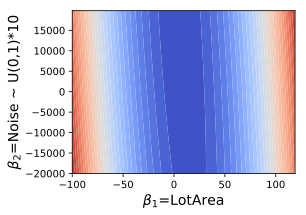

In [590]:
lm = LinearRegression()
lm.fit(X, y)
true_b0 = lm.intercept_
true_b1 = lm.coef_
print(f"True OLS b0 = {true_b0:.2f}, b_{{1..p}} = {str(true_b1)}")

b1_range = np.arange(-2,2+.1, .1)  # y intercept
b2_range = np.arange(-2,2+.1, .1)     # slope
b1_range = np.arange(-100,120, 1)  # y intercept
b2_range = np.arange(-20000,20000, 200)     # slope
L = get_surface(X, y, loss, b1_range=b1_range, b2_range=b2_range)

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)#, projection='3d')
#ax.view_init(elev=30, azim=45)
b1_range_mesh, b2_range_mesh = np.meshgrid(b1_range, b2_range, indexing='ij')
# surface = ax.plot_surface(b1_range_mesh, b2_range_mesh, L, alpha=0.7, cmap='coolwarm')
cset = plt.contourf(b1_range_mesh, b2_range_mesh, L, offset=0, cmap='coolwarm', levels=30)
ax.set_xlabel('$\\beta_1$=LotArea', fontsize=14)
ax.set_ylabel('$\\beta_2$=Noise ~ U(0,1)*10', fontsize=14)
# ax.plot([-2,2],[0,0], lw=.5, c='black')
# ax.plot([0,0],[-2,2], lw=.5, c='black')
plt.show()

True OLS b0 = -20165.33, b_{1..p} = [29.05730127 29.05730127]


/Users/parrt/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'offset'
  s)


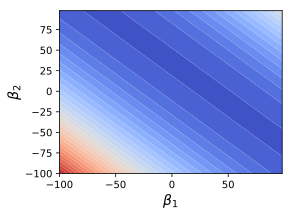

In [567]:
# Try with first 3 features
X = df_ames[['2ndFlrSF','2ndFlrSF']].copy()
y = df_ames['SalePrice']

#y = (y-np.mean(y)) / np.std(y)  # 0 center y so we can ignore y-intercept; scale down too
#normalize(X)
y = (y-np.mean(y))

lm = LinearRegression()
lm.fit(X, y)
true_b0 = lm.intercept_
true_b1 = lm.coef_
print(f"True OLS b0 = {true_b0:.2f}, b_{{1..p}} = {str(true_b1)}")

b1_range = np.arange(-8,8, .1)  # y intercept
b2_range = np.arange(-4,4, .1)     # slope
b1_range = np.arange(-100,100, 3)  # y intercept
b2_range = np.arange(-100,100, 3)     # slope
L = get_surface(X, y, loss, b1_range=b1_range, b2_range=b2_range)

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)#, projection='3d')
#ax.view_init(elev=80, azim=45)
b1_range_mesh, b2_range_mesh = np.meshgrid(b1_range, b2_range, indexing='ij')
#surface = ax.plot_surface(b1_range_mesh, b2_range_mesh, L, alpha=0.7, cmap='coolwarm')
ax.set_xlabel('$\\beta_1$', fontsize=14)
ax.set_ylabel('$\\beta_2$', fontsize=14)
cset = ax.contourf(b1_range_mesh, b2_range_mesh, L, offset=0, cmap='coolwarm', levels=30)
#ax2.contourf(x, y, z, facecolors=colors)
plt.show()

True OLS b0 = -123305.33, b_{1..p} = [7.47099218e+04 1.83842141e+01]


/Users/parrt/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'offset'
  s)


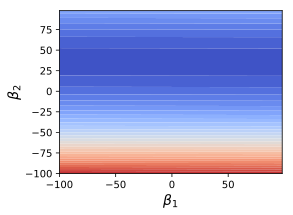

In [525]:
# Try with first 3 features
X = df_ames[['2ndFlrSF','FullBath']].copy()
X = df_ames[['FullBath','2ndFlrSF']].copy()
y = df_ames['SalePrice']

#y = (y-np.mean(y)) / np.std(y)  # 0 center y so we can ignore y-intercept; scale down too
#y = y / np.std(y)
y = (y-np.mean(y))
#normalize(X)

lm = LinearRegression()
lm.fit(X, y)
true_b0 = lm.intercept_
true_b1 = lm.coef_
print(f"True OLS b0 = {true_b0:.2f}, b_{{1..p}} = {str(true_b1)}")

b1_range = np.arange(-4,4, .1)  # y intercept
b2_range = np.arange(-4,4, .1)     # slope
b1_range = np.arange(-100,100, 3)  # y intercept
b2_range = np.arange(-100,100, 3)     # slope
L = get_surface(X, y, loss, b1_range=b1_range, b2_range=b2_range)

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)#, projection='3d')
#ax.view_init(elev=30, azim=45)
b1_range_mesh, b2_range_mesh = np.meshgrid(b1_range, b2_range, indexing='ij')
# surface = ax.plot_surface(b1_range_mesh, b2_range_mesh, L, alpha=0.7, cmap='coolwarm')
cset = plt.contourf(b1_range_mesh, b2_range_mesh, L, offset=0, cmap='coolwarm', levels=30)
ax.set_xlabel('$\\beta_1$', fontsize=14)
ax.set_ylabel('$\\beta_2$', fontsize=14)
plt.show()

True OLS b0 = -1.73, b_{1..p} = [1.96736379e-05 9.73120598e-01]


/Users/parrt/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'offset'
  s)


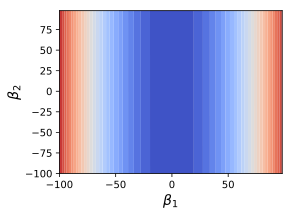

In [526]:
# Try with first 3 features
X = df_ames[['LotArea','FullBath']].copy()#,'FullBath']]LotArea
y = df_ames['SalePrice']

y = (y-np.mean(y)) / np.std(y)  # 0 center y so we can ignore y-intercept; scale down too
#normalize(X)

lm = LinearRegression()
lm.fit(X, y)
true_b0 = lm.intercept_
true_b1 = lm.coef_
print(f"True OLS b0 = {true_b0:.2f}, b_{{1..p}} = {str(true_b1)}")

b1_range = np.arange(-4,4, .1)  # y intercept
b2_range = np.arange(-2, 2, .1)     # slope
b1_range = np.arange(-100,100, 3)  # y intercept
b2_range = np.arange(-100,100, 3)     # slope
L = get_surface(X, y, loss, b1_range=b1_range, b2_range=b2_range)

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)#, projection='3d')
#ax.view_init(elev=30, azim=45)
b1_range_mesh, b2_range_mesh = np.meshgrid(b1_range, b2_range, indexing='ij')
# surface = ax.plot_surface(b1_range_mesh, b2_range_mesh, L, alpha=0.7, cmap='coolwarm')
cset = plt.contourf(b1_range_mesh, b2_range_mesh, L, offset=0, cmap='coolwarm', levels=30)
ax.set_xlabel('$\\beta_1$', fontsize=14)
ax.set_ylabel('$\\beta_2$', fontsize=14)
plt.show()